# Sampling Efficiency and Throughput
Investigating sample success rate as a product of network size.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from time import time
from labm8 import fs
from labm8 import system
from labm8.time import nowstr

import clgen
from clgen import corpus
from clgen import dbutil
from clgen import sampler
from clgen import model
from clgen import preprocess

**Experimental setup:**

In [2]:
rnn_sizes = [4, 8, 16] #[256, 512, 1024, 2048]
corpus_opts = {
    "path": "~/data/tiny" #"~/data/github"
}
training_opts = {
    "model_type": "lstm",
    "num_layers": 2, #3,
    "max_epochs": 1 #50
}
s = sampler.from_json({
    "kernels": {
        "args": [
            "__global float*",
            "__global float*",
            "__global float*",
            "const int"
        ],
        "max_length": 100, #5000,
        "temperature": 1
    },
    "sampler": {
        "batch_size": 50, #5000,
        "max_batches": 1,
        "static_checker": False,
        "dynamic_checker": False
    }
})

c = corpus.Corpus.from_json(corpus_opts)
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)
print()
clgen.platform_info()

Corpus size: 773245
Vocab size:  92

CLgen:      0.2.1 (with OpenCL)
Platform:   Darwin
Memory:     16384 MB

Device:     GPU Intel(R) Iris(TM) Graphics 6100
Compute #.: 48
Frequency:  1100 HZ
Memory:     1536 MB
Driver:     1.2(Oct 19 2016 00:25:08)


**Experimental methodology:**

In [3]:
def evaluate(model, sampler):
    """ evaluate sampling efficiency """
    model.cache.empty()  # clear checkpoint cache    
    tstart = time()  # start timer
    model.train(quiet=True)  # train model
    training_time = time() - tstart

    # clear the sample cache
    sampler.cache(model).empty()

    # sample kernels and time
    tstart = time()
    sampler.sample(model, quiet=True)
    tend = time()
    elapsed = tend - tstart

    # preprocess sample
    sample_db = sampler.cache(model)["kernels.db"]
    preprocess.preprocess_db(sample_db)

    num_kernels = dbutil.num_rows_in(sample_db, "ContentFiles")
    num_good_kernels = dbutil.num_good_kernels(sample_db)
    num_ugly_kernels = dbutil.num_rows_in(sample_db, "PreprocessedFiles",
                                          "WHERE status=2")
    discard_rate = 1 - (num_good_kernels / num_kernels)
    ugly_rate = 1 - (num_ugly_kernels / num_kernels)


    total_charcount = dbutil.cc(sample_db, "ContentFiles")
    good_charcount = dbutil.cc(sample_db, "PreprocessedFiles",
                               condition="WHERE status=0")

    efficiency = good_charcount / total_charcount
    throughput = good_charcount / elapsed

    return {
        "training_time": training_time,
        "sampling_time": elapsed,
        "num_kernels": num_kernels,
        "num_good_kernels": num_good_kernels,
        "discard_rate": discard_rate,
        "ugly_rate": ugly_rate,
        "total_charcount": total_charcount,
        "good_charcount": good_charcount,
        "efficiency": efficiency,  # good_chars/total_chars
        "throughput": throughput,  # good_chars/second
        "corpus_dir": model.corpus.cache.path,
        "model_dir": model.cache.path,
        "sampler_dir": sampler.cache(model).path,
    }

**Experimental results:**

In [ ]:
data_file = "./sampling-{host}.json".format(host=system.HOSTNAME)
# fs.rm(data_file)  # reset experimental data
data = clgen.load_json_file(data_file, must_exist=False)

for rnn_size in rnn_sizes:
    key = str(rnn_size)
    if key not in data:
        print("collecting result for", rnn_size, "...")
        training_opts["rnn_size"] = rnn_size
        m = model.from_json({
            "corpus": corpus_opts,
            "train_opts": training_opts
        })
        data[key] = evaluate(m, s)
    print("result", rnn_size, clgen.format_json(data[key]))
    clgen.write_file(data_file, clgen.format_json(data))
print("done", nowstr())
data

result 4 {
  "corpus_dir": "/Users/cec/.cache/clgen/0.2.1/corpus/6b4248154caa140665461619e4d1292eeee1b225",
  "discard_rate": 1.0,
  "efficiency": 0.0,
  "good_charcount": 0,
  "model_dir": "/Users/cec/.cache/clgen/0.2.1/model/2ebbde31f602394dc5a7a1725da28e2a8cc8c0b1",
  "num_good_kernels": 0,
  "num_kernels": 50,
  "sampler_dir": "/Users/cec/.cache/clgen/0.2.1/sampler/5def5c3571b88edaab82bf7203ec80ea3fa7ec63",
  "sampling_time": 11.293943881988525,
  "throughput": 0.0,
  "total_charcount": 4971,
  "training_time": 37.29821801185608,
  "ugly_rate": 0.98
}
result 8 {
  "corpus_dir": "/Users/cec/.cache/clgen/0.2.1/corpus/6b4248154caa140665461619e4d1292eeee1b225",
  "discard_rate": 1.0,
  "efficiency": 0.0,
  "good_charcount": 0,
  "model_dir": "/Users/cec/.cache/clgen/0.2.1/model/d7a40af55f2bbfb5b2673a66ddd1e15743042d02",
  "num_good_kernels": 0,
  "num_kernels": 49,
  "sampler_dir": "/Users/cec/.cache/clgen/0.2.1/sampler/d05856f17744e08925878ce13d92bb9baadf2a59",
  "sampling_time": 11.2

{'16': {'corpus_dir': '/Users/cec/.cache/clgen/0.2.1/corpus/6b4248154caa140665461619e4d1292eeee1b225',
  'discard_rate': 1.0,
  'efficiency': 0.0,
  'good_charcount': 0,
  'model_dir': '/Users/cec/.cache/clgen/0.2.1/model/d2bd2f31534be941928711e8831e282911488236',
  'num_good_kernels': 0,
  'num_kernels': 50,
  'sampler_dir': '/Users/cec/.cache/clgen/0.2.1/sampler/6d4863adc84158835c2bbcd4b609c7921cf1ec92',
  'sampling_time': 9.702114820480347,
  'throughput': 0.0,
  'total_charcount': 4983,
  'training_time': 41.60571098327637,
  'ugly_rate': 1.0},
 '4': {'corpus_dir': '/Users/cec/.cache/clgen/0.2.1/corpus/6b4248154caa140665461619e4d1292eeee1b225',
  'discard_rate': 1.0,
  'efficiency': 0.0,
  'good_charcount': 0,
  'model_dir': '/Users/cec/.cache/clgen/0.2.1/model/2ebbde31f602394dc5a7a1725da28e2a8cc8c0b1',
  'num_good_kernels': 0,
  'num_kernels': 50,
  'sampler_dir': '/Users/cec/.cache/clgen/0.2.1/sampler/5def5c3571b88edaab82bf7203ec80ea3fa7ec63',
  'sampling_time': 11.29394388198852

**Experimental results:**

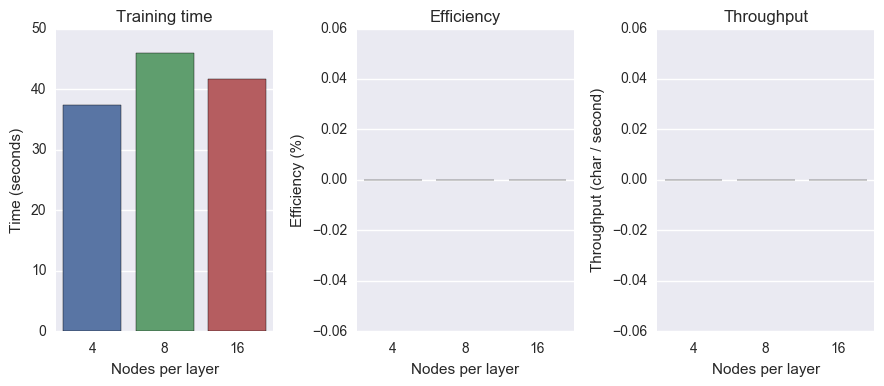

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from labm8 import viz

plt.subplots(1, 3)

plt.subplot(1, 3, 1)
x, y = zip(*[(int(x), data[x]["training_time"])
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Training time")
plt.xlabel("Nodes per layer")
plt.ylabel("Time (seconds)")
    
plt.subplot(1, 3, 2)
x, y = zip(*[(int(x), data[x]["efficiency"] * 100)
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Efficiency")
plt.xlabel("Nodes per layer")
plt.ylabel("Efficiency (%)")
    
plt.subplot(1, 3, 3)
x, y = zip(*[(int(x), data[x]["throughput"])
             for x in sorted(data.keys(), key=lambda x: int(x))])
sns.barplot(x, y)
plt.title("Throughput")
plt.xlabel("Nodes per layer")
plt.ylabel("Throughput (char / second)")

viz.finalise(figsize=(9, 4))